# Solar Power Generation Data

### Tutorial for time series analysis
https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

### Data taken from 
https://www.kaggle.com/fvcoppen/solarpanelspower

### Kernel followed
https://www.kaggle.com/fvcoppen/101-univariate-and-cnn-model-on-daily-solar-power


# Business question to be asked.
1 - Given the data predict the solar power for the next year.
2 - Does seasonality - such as winter, summer, spring, etc. - plays a role in power generated per day?
3 - Is there a variation during different time of the day (morning, noon, evening)?
4 - Considering the dollar per watts charged by utility company, how much one can save in on month/one year?
5 - If total cost of installation is 25K for 5KW system, how long will it take to pay off the cost of system?



The file PVElecGas2.csv is ';' separated and has 4 columns: 
 - Date, 
 - Cumulative solar power, 
 - used kWh electricity, 
 - used Gas m²


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import keras as K


In [2]:
print('tf version', tf.__version__)
print('keras version', K.__version__)

tf version 2.3.0
keras version 2.4.3


## Read the files

In [3]:


from pathlib import Path
file_dir = Path('/Users/khan_m_a/Google Drive/Data_Science/Kaggle/Solar Power/data')

solarpower = pd.read_csv(file_dir / 'PV_Elec_Gas2.csv', 
                         names = ['Date', 'cum_solar_power', 'ele_kw', 'gas_mxm'],
                        skiprows = 1,
                        parse_dates = { 'dt': ['Date']},
                        index_col = 'dt')


In [4]:
solarpower.head()

,cum_solar_power,ele_kw,gas_mxm
dt,,,
2011-10-26,0.1,15.1,9.0
2011-10-27,10.2,7.4,9.2
2011-10-28,20.2,5.8,8.0
2011-10-29,29.6,4.9,6.6
2011-10-30,34.2,11.7,5.3


In [5]:
solarpower.info(), solarpower.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2948 entries, 2011-10-26 to 2019-11-20
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cum_solar_power  2948 non-null   float64
 1   ele_kw           2948 non-null   float64
 2   gas_mxm          2948 non-null   float64
dtypes: float64(3)
memory usage: 92.1 KB


(None, (2948, 3))

### Data Cleaning

##### since the second column is cumulative solar power, we need to convert into daily solar power

In [6]:
# testing shift command

small_sp = solarpower[: '2011-10-31'].copy()
small_sp_shift =  small_sp.shift(periods =1, axis=0, freq = 'D')

In [7]:
small_sp.head(), small_sp_shift.head()

(            cum_solar_power  ele_kw  gas_mxm
 dt                                          
 2011-10-26              0.1    15.1      9.0
 2011-10-27             10.2     7.4      9.2
 2011-10-28             20.2     5.8      8.0
 2011-10-29             29.6     4.9      6.6
 2011-10-30             34.2    11.7      5.3,
             cum_solar_power  ele_kw  gas_mxm
 dt                                          
 2011-10-27              0.1    15.1      9.0
 2011-10-28             10.2     7.4      9.2
 2011-10-29             20.2     5.8      8.0
 2011-10-30             29.6     4.9      6.6
 2011-10-31             34.2    11.7      5.3)

In [8]:
small_sp['cum_p_shift'] = small_sp_shift['cum_solar_power']
small_sp['day_solar_power'] = small_sp['cum_solar_power'].values - small_sp['cum_p_shift'].values
del small_sp['cum_solar_power'], small_sp['cum_p_shift']
small_sp

,ele_kw,gas_mxm,day_solar_power
dt,,,
2011-10-26,15.1,9.0,NaN
2011-10-27,7.4,9.2,10.1
2011-10-28,5.8,8.0,10.0
2011-10-29,4.9,6.6,9.4
2011-10-30,11.7,5.3,4.6
2011-10-31,11.0,5.7,3.8


In [9]:
solarpower_temp = solarpower.shift(periods =1, axis=0, freq='D')
solarpower['cum_p_shift'] = solarpower_temp['cum_solar_power']
solarpower['day_solar_power'] = solarpower['cum_solar_power'] - solarpower['cum_p_shift']
solarpower.dropna(axis=0, inplace = True)

In [10]:
solarpower.head(3), solarpower.tail(3)

(            cum_solar_power  ele_kw  gas_mxm  cum_p_shift  day_solar_power
 dt                                                                        
 2011-10-27             10.2     7.4      9.2          0.1             10.1
 2011-10-28             20.2     5.8      8.0         10.2             10.0
 2011-10-29             29.6     4.9      6.6         20.2              9.4,
             cum_solar_power  ele_kw  gas_mxm  cum_p_shift  day_solar_power
 dt                                                                        
 2019-11-18          32238.0    13.0     14.0      32235.0              3.0
 2019-11-19          32238.0    13.0     15.0      32238.0              0.0
 2019-11-20          32244.0     9.0     16.0      32238.0              6.0)

In [11]:

solarpower.drop(['cum_p_shift', 'cum_solar_power'], 
                             axis=1, inplace = True)

In [12]:
solarpower.head(), solarpower.tail()

(            ele_kw  gas_mxm  day_solar_power
 dt                                          
 2011-10-27     7.4      9.2             10.1
 2011-10-28     5.8      8.0             10.0
 2011-10-29     4.9      6.6              9.4
 2011-10-30    11.7      5.3              4.6
 2011-10-31    11.0      5.7              3.8,
             ele_kw  gas_mxm  day_solar_power
 dt                                          
 2019-11-16    12.0     15.0              2.0
 2019-11-17    13.0     14.0              4.0
 2019-11-18    13.0     14.0              3.0
 2019-11-19    13.0     15.0              0.0
 2019-11-20     9.0     16.0              6.0)

### EDA

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdb5e37db10>,
      dtype=object)

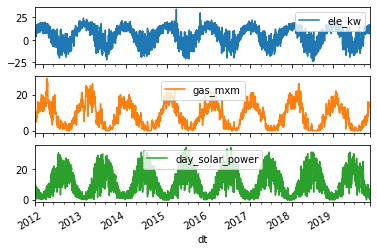

In [13]:
solarpower.plot(subplots = True)

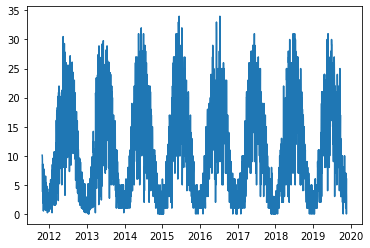

In [14]:
fig, ax = plt.subplots()
ax.plot('day_solar_power', data = solarpower)
# plt.xlim(datetime.date(2012,1,1),datetime.date(2013,1,1) )
plt.show()

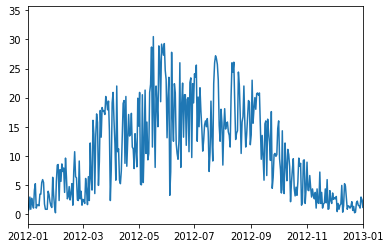

In [15]:
fig, ax = plt.subplots()
ax.plot('day_solar_power', data = solarpower)
plt.xlim(datetime.date(2012,1,1),datetime.date(2013,1,1) )
plt.show()

As we clearly see there is a seasonality in data. During summer, the solar output is higher than winter months.

### Split the data, leaving last 365 days for validation


In [16]:
solarpower.head(), solarpower.tail(), solarpower.shape

(            ele_kw  gas_mxm  day_solar_power
 dt                                          
 2011-10-27     7.4      9.2             10.1
 2011-10-28     5.8      8.0             10.0
 2011-10-29     4.9      6.6              9.4
 2011-10-30    11.7      5.3              4.6
 2011-10-31    11.0      5.7              3.8,
             ele_kw  gas_mxm  day_solar_power
 dt                                          
 2019-11-16    12.0     15.0              2.0
 2019-11-17    13.0     14.0              4.0
 2019-11-18    13.0     14.0              3.0
 2019-11-19    13.0     15.0              0.0
 2019-11-20     9.0     16.0              6.0,
 (2947, 3))

In [17]:
# split and normalize data

train = solarpower[: '2018-11-20']
valid = solarpower[ '2018-11-21': '2019-11-20'] # last 365 days

train.shape, valid.shape

((2582, 3), (365, 3))

In [18]:
## do we need to store anything check again predictions?

### Date Preparation

In [19]:
# concept taken from here
# https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

def split_window(series, window):
    X, y = [], []
    no_steps = len(series) - window
    for step in range(no_steps):
        X.append(series[step : step + window])
        y.append(series[step + window])
    X = np.array(X)
    y = np.array(y)
    return X, y

In [20]:
# test with small array
series = np.array([10,20,30,40,50,60,70,80,90])
a, b = split_window(series, 3)
print(a,b)

[[10 20 30]
 [20 30 40]
 [30 40 50]
 [40 50 60]
 [50 60 70]
 [60 70 80]] [40 50 60 70 80 90]


In [21]:
# applying split_window on day_solar_power with window = 365
window = 365
train_day_power = train['day_solar_power'].values
X, y = split_window(train_day_power, window)

# check couple of samples
for i in range(5):
    print(X[i][-10:], y[i])


[7.6 9.5 4.4 3.1 4.6 3.2 5.5 9.6 8.2 8.7] 1.5
[9.5 4.4 3.1 4.6 3.2 5.5 9.6 8.2 8.7 1.5] 2.0
[4.4 3.1 4.6 3.2 5.5 9.6 8.2 8.7 1.5 2. ] 9.200000000000273
[3.1 4.6 3.2 5.5 9.6 8.2 8.7 1.5 2.  9.2] 9.299999999999727
[4.6 3.2 5.5 9.6 8.2 8.7 1.5 2.  9.2 9.3] 1.800000000000182


### Conv1D Model - Univariate input

In [22]:
#https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

def my_conv1d_model(window, n_features = 1):
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(filters = 32, kernel_size = 3,
                    activation = 'relu', 
                    input_shape = (window, n_features)))
    model.add(tf.keras.layers.MaxPooling1D(pool_size = 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(50, activation = 'relu'))
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(optimizer = 'adam', loss = 'mae')
#     model.summary()
    return model

In [23]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# call the model function
model = my_conv1d_model(window, n_features)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 363, 32)           128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 181, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 5792)              0         
_________________________________________________________________
dense (Dense)                (None, 50)                289650    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 289,829
Trainable params: 289,829
Non-trainable params: 0
_________________________________________________________________


In [24]:
#fit the model

history = model.fit(X, y, epochs = 500, verbose = 0)

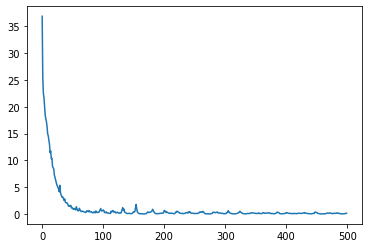

In [25]:
#plot the loss function
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])

In [26]:
# forgot to normalize the column. 
# note to self.......normalize column and re-run again.

In [33]:
train.columns

Index(['ele_kw', 'gas_mxm', 'day_solar_power'], dtype='object')

In [37]:
# predicting next year based on model

x_in = np.array(train.day_solar_power[-365:]) # last 365 days

#reshape to (samples, window, features) format
x_in = x_in.reshape((1, window, n_features))

#predict and add to the x_in
for i in range(365):
    y_hat = model.predict(x_in, verbose = 0)
    new_x = y_hat.reshape((1,1,1))
    x_in = np.concatenate((x_in[: , -364:], new_x), axis =1)



In [38]:
x_in.shape

(1, 365, 1)

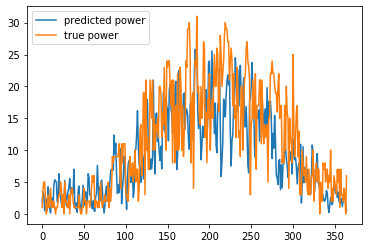

In [42]:
y_pred = x_in.reshape((x_in.shape[1]))
plt.plot(y_pred, label = 'predicted power')

y_true = valid.day_solar_power.values
plt.plot(y_true, label = 'true power')
plt.legend()
plt.show()

In [43]:
univar_r2 = r2_score(y_true, y_pred)
univar_mae = mean_absolute_error(y_true, y_pred)
print('r2 score is ', univar_r2)
print('mae is ', univar_mae)

r2 score is  0.40630222973236196
mae is  4.693220946070266


In [46]:
# What about cumulative power

def cumulated(series, start=0):
    cm = [start]
    for i in range(len(series)):
        add_last = cm[i] + series[i]
        cm.append(add_last)
    return cm



In [48]:
temp = np.array([10,20,30,40,50,60,70,80,90])
print(cumulated(temp))

[0, 10, 30, 60, 100, 150, 210, 280, 360, 450]


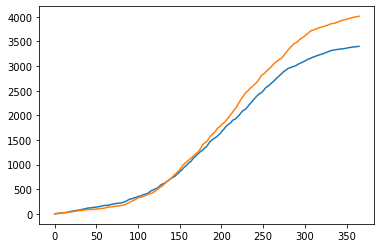

In [49]:
y_true_cum = cumulated(y_true)
y_pred_cum = cumulated(y_pred)

plt.plot(y_pred_cum)
plt.plot(y_true_cum)

In [ ]:
# accuracey after one year



### LSTM Model

In [27]:
solarpower.shape,X.shape, y.shape

((2947, 3), (2217, 365, 1), (2217,))

In [28]:
# create a model function

def my_lstm_model(input_series):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(8, input_shape = input_series.shape[-2:]),
        tf.keras.layers.Dense(1)    
        
    ])
    model.compile(optimizer = 'adam', loss = 'mae')
    
    return model


In [50]:
# model = my_lstm_model()